# **Language Model**
2023-02-01

1. DataLoader
2. Model
3. Trainer
4. Generation

 RNN기반의 Language Model 구현 & 텍스트 생성

- dataset: WikiText2 (https://github.com/pytorch/examples/tree/master/word_language_model/data/wikitext-2)
- model: LSTM




## Import packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1+cu116
True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import os
import random
import time
import datetime

# for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. DataLoader

### Dataset

데이터셋은 Wikipedia에 있는 영문 글들을 가져온 WikiTree dataset
불러올 데이터는 WikiTree dataset에서 <자주 사용되지 않는 단어>나 <영어가 아닌 단어>들은 <unk>으로 이미 전처리가 되어있다.

In [3]:
import urllib
with urllib.request.urlopen('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/02-intermediate/language_model/data/train.txt') as f:
    data = f.readlines()

In [4]:
print('num_sentence:',len(data))
data[100]

num_sentence: 42068


b" plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report \n"

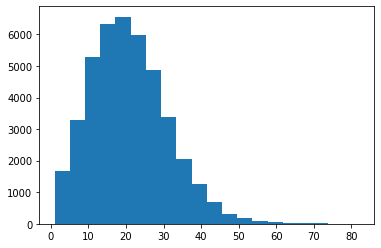

In [5]:
seq_length_list = []
for line in data:
    seq_length_list.append(len(line.split()))

counts, bins = np.histogram(seq_length_list, bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

데이터에 있는 문장 길이들의 histogram을 볼 때 대부분의 data의 문장 길이가 50에 미치지 못하기 때문에 \\
model에 집어넣을 최대 문장 길이를 50으로 세팅

In [6]:
max_seq_len = 50

### Build Dictionary

text에 존재하는 단어들을 index로 변환한다.

이를 위해서 단어를 index로 변환해주는 word2idx dictionary와 다시 index를 단어로 변환해주는 idx2word dictionary를 구현


In [7]:
def build_dictionary(data, max_seq_len):
    word2idx = {}
    idx2word = {}
    ## Build Dictionary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    idx = 2
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]        
        ### Build Dictionary to convert word to index and index to word
        ### YOUR CODE HERE (~ 5 lines)
        for word in words:
            if word not in word2idx:
                word2idx[word] = idx
                idx2word[idx] = word
                idx += 1

    return word2idx, idx2word

word2idx, idx2word = build_dictionary(data, max_seq_len)

In [8]:
if len(word2idx) == len(idx2word) == 10000:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


### Preprocessing

text로된 데이터셋을 index들로 변환

In [9]:
def preprocess(data, word2idx, idx2word, max_seq_len):
    tokens = []
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]
        ### Convert dataset with tokens
        ### For each line, append <pad> token to match the number of max_seq_len
        ### YOUR CODE HERE (~ 4 lines)
        words += ['<pad>']*(max_seq_len - len(words))
        for word in words:
            token = word2idx[word]
            tokens.append(token)

    return tokens

tokens = preprocess(data, word2idx, idx2word, max_seq_len)

In [10]:
if len(tokens) == 2103400:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


전처리된 Token들을 문장 단위의 배열로 변환

In [11]:
tokens = np.array(tokens).reshape(-1, max_seq_len)
print(tokens.shape)
tokens[100]

(42068, 50)


array([745,  93, 746, 739, 747, 181, 748, 467, 749, 740, 750, 154, 751,
       752,   1, 160,  32, 753,   1,  48, 754,  32, 755, 756, 757, 728,
       555, 758,  99, 119, 555, 733,  48,   1, 759,   1, 119, 237, 753,
       230, 760, 347,   0,   0,   0,   0,   0,   0,   0,   0])

### DataLoader

Token형태의 데이터를 PyTorch 스타일 dataset으로 만들 때 주의점 : embedding matrix에서 indexing을 해주기 위해서 각 token이 LongTensor 형태로 정의되어야 한다.

In [12]:
class LMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens):
        super(LMDataset, self).__init__()
        self.PAD = 0
        self.UNK = 1
        self.tokens = tokens
        self._getitem(2)

    def _getitem(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).unsqueeze(0).long()
        y = torch.from_numpy(y).unsqueeze(0).long()

        return X, y

    def __getitem__(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).long()
        y = torch.from_numpy(y).long()

        return X, y

    def __len__(self):
        return len(self.tokens)

In [13]:
batch_size = 64
dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset))
print(len(dataloader))

42068
658


# 2. Model

**Language Modeling을 위한 Recurrent Model**

Standard한 Recurrent Neural Network (RNN) model은 vanishing gradient 문제에 취약하기 때문에, 변형된 RNN구조인 LSTM model을 활용


### LSTM

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [14]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # input-gate
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        # forget-gate
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        # gate-gate
        self.Wg = nn.Linear(input_size + hidden_size, hidden_size)
        # output-gate
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)

        # non-linearity
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_0, c_0):
        """
        Inputs
            input (x): [batch_size, input_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
        Outputs
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        h_1, c_1 = None, None
        input = torch.cat((x, h_0), 1)
        # Implement LSTM cell as noted above
        ### YOUR CODE HERE (~ 6 lines)
        i = self.sigmoid(self.Wi(input))
        f = self.sigmoid(self.Wf(input))
        g = self.tanh(self.Wg(input))
        o = self.sigmoid(self.Wo(input))
        c_1 = f * c_0 + i * g
        h_1 = o * self.tanh(c_1)

        return h_1, c_1

In [15]:
def test_lstm():
    batch_size = 2
    input_size = 5
    hidden_size = 3

    #torch.manual_seed(1234)
    lstm = LSTMCell(input_size ,hidden_size)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.constant_(m.weight, 0.1)
            m.bias.data.fill_(0.01)
    lstm.apply(init_weights)

    x = torch.ones(batch_size, input_size)
    hx = torch.zeros(batch_size, hidden_size)
    cx = torch.zeros(batch_size, hidden_size)

    hx, cx = lstm(x, hx, cx)
    assert hx.detach().allclose(torch.tensor([[0.1784, 0.1784, 0.1784], 
                                              [0.1784, 0.1784, 0.1784]]), atol=2e-1), \
            f"Output of the hidden state does not match."
    assert cx.detach().allclose(torch.tensor([[0.2936, 0.2936, 0.2936], 
                                              [0.2936, 0.2936, 0.2936]]), atol=2e-1), \
            f"Output of the cell state does not match."

    print("==LSTM cell test passed!==")

test_lstm()

==LSTM cell test passed!==


## Language Model

In [16]:
class LanguageModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=64, vocab_size=10000):
        super(LanguageModel, self).__init__()
        
        self.input_layer = nn.Embedding(vocab_size, input_size)
        self.hidden_layer = LSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, hx, cx, predict=False):
        """
        Inputs
            input (x): [batch_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
            predict: whether to predict and sample the next word
        Outputs
            output (ox): [batch_size, hidden_size]
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        x = self.input_layer(x)
        hx, cx = self.hidden_layer(x, hx, cx)
        ox = self.output_layer(hx)

        if predict == True:
            probs = F.softmax(ox, dim=1)
            # torch distribution allows sampling operation
            # see https://pytorch.org/docs/stable/distributions.html
            dist = torch.distributions.Categorical(probs)
            ox = dist.sample()

        return ox, hx, cx  

# 3. Trainer


In [17]:
class Trainer():
    def __init__(self, 
                 word2idx, 
                 idx2word,
                 dataloader, 
                 model, 
                 criterion,
                 optimizer, 
                 device):
        """
        dataloader: dataloader
        model: langauge model
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        optimizer: optimizer for model
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataloader = dataloader
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def train(self, epochs = 1):
        self.model.to(self.device)
        start_time = time.time()
        for epoch in range(epochs):
            losses = []
            for iter, (x_batch, y_batch) in tqdm.tqdm(enumerate(self.dataloader)):
                self.model.train()
                
                batch_size, max_seq_len = x_batch.shape
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # initial hidden-states
                hx = torch.zeros(batch_size, hidden_size).to(self.device)
                cx = torch.zeros(batch_size, hidden_size).to(self.device)

                # Implement LSTM operation
                ox_batch = []
                # Get output logits for each time sequence and append to the list, ox_batch
                # YOUR CODE HERE (~ 4 lines)
                for s_idx in range(max_seq_len):
                    x = x_batch[:, s_idx]
                    ox, hx, cx = self.model(x, hx, cx)
                    ox_batch.append(ox)
                # outputs are ordered by the time sequence
                ox_batch = torch.cat(ox_batch).reshape(max_seq_len, batch_size, -1)
                ox_batch = ox_batch.permute(1,0,2).reshape(batch_size*max_seq_len, -1)
                y_batch = y_batch.reshape(-1)

                self.model.zero_grad()
                loss = self.criterion(ox_batch, y_batch)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], loss: %.4f'
                  % (end_time, epoch+1, epochs, np.mean(losses)))
            if epoch % 5 == 0:
                generated_sentences = self.test()
                print('[Generated Sentences]')
                for sentence in generated_sentences:
                    print(sentence)
            
    def test(self):
        # Test model to genereate the sentences
        self.model.eval()
        num_sentence = 5
        max_seq_len = 50

        # initial hidden-states
        outs = []
        x = torch.randint(0, 10000, (num_sentence,)).to(self.device)
        hx = torch.zeros(num_sentence, hidden_size).to(self.device)
        cx = torch.zeros(num_sentence, hidden_size).to(self.device)

        outs.append(x)
        with torch.no_grad():
            for s_idx in range(max_seq_len-1):
                x, hx, cx = self.model(x, hx, cx, predict=True)
                outs.append(x)
        outs = torch.cat(outs).reshape(max_seq_len, num_sentence)
        outs = outs.permute(1, 0)
        outs = outs.detach().cpu().numpy()

        sentences = []
        for out in outs:
            sentence = []
            for token_idx in out:
                word = self.idx2word[token_idx]
                sentence.append(word)
            sentences.append(sentence)
       
        return sentences

In [18]:
for iter,(x_batch,y_batch) in (enumerate(dataloader)):
    print(x_batch.shape)

torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([6

In [19]:
lr = 1e-2
input_size = 128
hidden_size = 128
batch_size = 256

dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = LanguageModel(input_size=input_size, hidden_size=hidden_size)
# NOTE: Use ignore_index to ignore the loss from predicting the <PAD> token
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device('cuda')

trainer = Trainer(word2idx = word2idx,
                  idx2word = idx2word,
                  dataloader=dataloader, 
                  model = model,
                  criterion=criterion,
                  optimizer = optimizer,
                  device=device)

trainer.train(epochs=50)

165it [00:21,  7.85it/s]


Time [0:00:21], Epoch [1/50], loss: 6.1041
[Generated Sentences]
['paying', 'plight', 'last', 'mail', 'junk', 'bonds', 'changed', 'h&r', 'him', 'as', 'new', 'products', 'from', 'current', 'activity', 'music', 'less', 'than', 'the', 'no.', 'until', 'this', 'month', 'when', 'he', 'added', 'the', 'end', 'on', '<unk>', 'the', 'supreme', 'department', "'s", 'restored', '<unk>', 'no', 'tourism', 'nasty', 'making', 'it', "'s", 'writers', 'on', 'an', 'core', 'total', 'river', 'sales', 'trillion']
['invested', 'courtaulds', 'the', 'beverly', 'one', 'day', 'this', 'year', 'never', 'consistently', 'not', 'disclosed', 'available', 'of', 'mr.', 'hastings', 'in', 'philadelphia', 'dropped', 'N', 'out', 'in', 'legislation', 'to', 'meet', 'controlled', 'to', 'accept', 'the', 'red', 'ford', 'transaction', 'contracts', 'resources', 'sen.', 'james', 'entry', 'nearly', 'futures', 'bags', 'total', 'investment', 'N', 'billion', 'yen', '$', 'N', 'million', 'or', 'N']
['notorious', 'social', 'wrongdoing', 'the

165it [00:15, 10.59it/s]


Time [0:00:36], Epoch [2/50], loss: 5.2393


165it [00:16, 10.08it/s]


Time [0:00:53], Epoch [3/50], loss: 4.9173


165it [00:15, 10.52it/s]


Time [0:01:08], Epoch [4/50], loss: 4.7097


165it [00:15, 10.55it/s]


Time [0:01:24], Epoch [5/50], loss: 4.5509


165it [00:15, 10.67it/s]


Time [0:01:39], Epoch [6/50], loss: 4.4211
[Generated Sentences]
['design', 'korea', 'and', 'exchange', 'commission', 'will', 'help', 'losing', 'revenue', 'in', '<unk>', 'chancery', 'business', 'products', 'to', 'be', 'dominated', 'by', 'the', 'international', 'airport', '<unk>', 'institute', 'a', 'factor', 'of', '<unk>', '<unk>', 'space', 'probe', 'some', 'tricky', 'bench', 'may', 'seek', 'to', 'carry', 'some', '<unk>', 'in', 'a', 'former', 'european', 'community', 'research', 'firm', 'said', 'extended', 'construction', 'spending']
['skeptical', 'south', 'korean', 'foreign', 'investment', 'trust', 'fell', 'N', 'cents', 'to', '$', 'N', 'billion', 'to', '$', 'N', 'billion', 'up', 'N', 'cents', 'a', 'share', 'compared', 'with', 'its', 'first', 'boston', 'examiner', 'essential', 'to', '<unk>', 'advertising', 'and', 'miller', 'other', 'categories', "'s", 'computer', 'processing', 'computer', 'to', 'sell', 'frankfurt', 'markets', 'said', 'the', 'weakening', 'is', 'a', 'charge']
['leave', 't

165it [00:15, 10.61it/s]


Time [0:01:55], Epoch [7/50], loss: 4.3145


165it [00:15, 10.61it/s]


Time [0:02:11], Epoch [8/50], loss: 4.2224


165it [00:15, 10.65it/s]


Time [0:02:26], Epoch [9/50], loss: 4.1427


165it [00:15, 10.63it/s]


Time [0:02:42], Epoch [10/50], loss: 4.0706


165it [00:15, 10.63it/s]


Time [0:02:57], Epoch [11/50], loss: 4.0093
[Generated Sentences]
['green', 'teams', 'the', 'marketplace', 'i', 'believe', 'there', 'was', 'the', '<unk>', 'of', 'my', 'own', 'with', 'schools', 'while', 'cycling', 'complained', 'that', 'they', "'ve", 'been', 'confiscated', 'or', 'more', '<unk>', 'than', 'california', "'s", 'play', 'rather', 'than', 'blacks', 'they', 'discover', 'that', 'we', 'need', 'any', 'settlement', 'it', 'was', "n't", "n't", 'in', 'returns', 'to', 'their', 'own', 'quarterly']
['summit', 'offset', 'yesterday', 'discontinued', 'chemicals', 'projects', 'that', 'were', 'continuing', 'slightly', 'lower', 'at', 'N', 'p.m.', 'est', 'on', 'a', 'proving', 'to', 'do', 'differently', 'on', 'the', 'new', 'york', 'stock', 'exchange', 'the', 'industry', 'business', 'of', 'ual', 'mining', 'the', 'u.k.', 'and', 'at', '$', 'N', 'range', 'with', 'N', 'N', 'off', 'N', 'almost', 'N', 'million', 'shares', 'outstanding']
['corporations', 'at', 'home', 'shopping', 'and', 'permitting', 'e

165it [00:15, 10.61it/s]


Time [0:03:13], Epoch [12/50], loss: 3.9534


165it [00:15, 10.61it/s]


Time [0:03:28], Epoch [13/50], loss: 3.9003


165it [00:16, 10.31it/s]


Time [0:03:44], Epoch [14/50], loss: 3.8555


165it [00:15, 10.60it/s]


Time [0:04:00], Epoch [15/50], loss: 3.8137


165it [00:15, 10.59it/s]


Time [0:04:15], Epoch [16/50], loss: 3.7761
[Generated Sentences]
['l.p.', 'motors', 'corp.', 'placed', 'as', 'a', '<unk>', 'assistant', 'vice', 'president', 'of', 'circus', 'enterprises', 'for', 'the', 'sight', 'soon', 'discover', 'no', 'federal', 'regulations', 'will', 'be', 'followed', 'until', 'the', 'irs', 'may', 'be', '<unk>', 'anyway', 'anything', 'wants', 'just', 'about', 'N', 'N', 'of', 'bonds', 'due', 'in', 'N', 'hours', 'of', 'series', 'the', '<unk>', 'radar', 'plant', 'and']
['transatlantic', 'termed', 'interviews', 'against', 'it', 'with', 'the', 'additional', 'liquidity', 'will', 'probably', 'determine', 'if', '<unk>', 'has', 'big', 'commitments', 'a', 'long', 'way', 'through', '<unk>', 'that', 'goes', 'on', 'his', 'desk', "'s", 'members', 'yesterday', 'so', '<unk>', 'a', 'lot', 'of', 'casinos', 'bonds', 'took', 'a', 'setback', 'for', 'retiring', 'and', 'filed', 'against', 'a', 'boat', 'in', 'federal', 'court']
['low-cost', 'cardiovascular', 'who', 'used', 'a', 'tax', 'cu

165it [00:15, 10.62it/s]


Time [0:04:31], Epoch [17/50], loss: 3.7386


165it [00:15, 10.52it/s]


Time [0:04:47], Epoch [18/50], loss: 3.7065


165it [00:15, 10.61it/s]


Time [0:05:02], Epoch [19/50], loss: 3.6777


165it [00:15, 10.56it/s]


Time [0:05:18], Epoch [20/50], loss: 3.6505


165it [00:15, 10.53it/s]


Time [0:05:34], Epoch [21/50], loss: 3.6238
[Generated Sentences]
['kkr', 'had', 'five', 'radio', 'in', 'its', '<unk>', 'union', 'owning', 'the', 'financial', 'markets', 'today', 'took', 'place', 'in', 'social', 'buying', 'deregulation', 'in', 'a', '<unk>', 'scale', 'this', 'next', 'year', 'mr.', 'wathen', "'s", 'articles', 'of', 'workers', '<unk>', 'and', 'fish', 'in', 'economic', 'affairs', 'and', 'the', 'balance', 'of', 'workers', 'from', 'these', 'reasons', 'i', 'believe', 'i', 'want']
['referred', 'cowboys', 'as', 'an', 'accord', 'with', 'jaguar', 'about', 'half', 'of', 'N', 'rather', 'an', 'arms-control', 'spokeswoman', 'for', 'europe', 'in', 'its', 'history', 'in', 'a', 'house-senate', 'conference', 'on', 'the', 'bottom', 'end', 'because', 'gene', 'is', 'often', 'difficult', 'in', 'the', 'field', 'immediately', 'wider', '<unk>', 'passengers', 'onto', 'colombian', 'treasury', 'bill', 'toward', 'which', 'N', 'N', 'of', 'the']
['gerrymandering', 'from', 'eduard', 'shevardnadze', '<

165it [00:15, 10.56it/s]


Time [0:05:49], Epoch [22/50], loss: 3.5993


165it [00:15, 10.57it/s]


Time [0:06:05], Epoch [23/50], loss: 3.5767


165it [00:15, 10.51it/s]


Time [0:06:21], Epoch [24/50], loss: 3.5552


165it [00:15, 10.53it/s]


Time [0:06:36], Epoch [25/50], loss: 3.5368


165it [00:15, 10.57it/s]


Time [0:06:52], Epoch [26/50], loss: 3.5185
[Generated Sentences]
['impeachment', 'viewpoint', 'yankee', 'interpreted', 'the', 'wall', 'street', 'firms', 'are', 'already', 'highly', 'declining', 'than', 'N', 'N', 'of', 'turner', 'broadcasting', 'of', 'the', 'philippines', 'fled', 'the', 'market', 'or', 'about', 'N', 'newsweek', '<unk>', 'texas', 'or', 'new', 'homes', '<unk>', 'from', 'the', 'atlantic', 'coast', 'design', 'and', 'teaching', 'methods', 'and', 'circus', '<unk>', '<unk>', 'like', 'earthquakes', 'here', 'in']
['day', 'could', 'enjoy', 'action', 'to', 'focus', 'on', 'human', 'services', 'to', 'sell', 'through', 'ual', 'radio', 'in', 'federal', 'aid', 'that', 'would', 'otherwise', 'have', 'on', 'a', 'larger', 'basis', 'in', 'areas', 'with', 'their', 'profits', 'said', 'james', 'h.', 'miller', 'gold', 'manager', 'of', 'japan', "'s", 'largest', 'accounts', 'through', 'its', 'suit', 'against', 'the', 'rebel', 'units', 'and', 'a']
['bankruptcy-law', 'medium-sized', 'stop', 'fishe

165it [00:15, 10.57it/s]


Time [0:07:08], Epoch [27/50], loss: 3.5014


165it [00:15, 10.42it/s]


Time [0:07:23], Epoch [28/50], loss: 3.4847


165it [00:15, 10.37it/s]


Time [0:07:39], Epoch [29/50], loss: 3.4714


165it [00:15, 10.57it/s]


Time [0:07:55], Epoch [30/50], loss: 3.4566


165it [00:15, 10.58it/s]


Time [0:08:11], Epoch [31/50], loss: 3.4425
[Generated Sentences]
['estimated', 'late', 'friday', 'and', 'when', 'its', 'businesses', 'and', 'the', 'restructuring', 'could', 'invest', 'big', 'institutional', 'investors', 'association', 'or', 'adequate', 'on', 'its', 'borrowings', 'has', 'outperformed', 'nearly', 'did', "n't", 'an', 'additional', 'N', 'three', 'months', 'bank', 'operating', 'index', 'and', 'a', 'second', 'quarterly', 'report', 'by', 'the', 'recent', 'price', 'of', 'its', 'N', 'securities', 'act', 'rated', 'single-a-1']
['bnl', 'has', 'N', 'million', 'common', 'shares', 'later', 'suspended', 'compared', 'with', 'a$', 'N', 'billion', 'in', 'assets', 'and', 'large', 'corporations', 'but', 'with', 'real-estate', 'sales', 'and', 'general', 'dynamics', 'corp.', 'posted', 'lower', 'earnings', 'for', '<unk>', "'s", 'life', 'of', 'the', '<unk>', 'of', 'a', 'new', 'business', 'which', 'separately', 'city', 'high-risk', 'transactions', 'valued', 'at', 'more', 'than', 'half']
['con

165it [00:15, 10.53it/s]


Time [0:08:26], Epoch [32/50], loss: 3.4309


165it [00:15, 10.61it/s]


Time [0:08:42], Epoch [33/50], loss: 3.4205


165it [00:15, 10.59it/s]


Time [0:08:57], Epoch [34/50], loss: 3.4115


165it [00:15, 10.56it/s]


Time [0:09:13], Epoch [35/50], loss: 3.3955


165it [00:15, 10.51it/s]


Time [0:09:29], Epoch [36/50], loss: 3.3887
[Generated Sentences]
['episode', 'sometimes', 'former', '<unk>', 'all', 'has', 'forecast', 'a', 'surprise', 'washington', 'work', 'focusing', 'on', 'image', 'but', '<unk>', 'affairs', 'who', 'have', 'faced', 'with', 'many', 'employers', 'grant', 'such', 'that', 'post', 'and', 'said', 'a', 'group', 'of', 'chrysler', 'and', 'international', 'coal', 'and', 'others', 'are', 'expected', 'to', 'raise', 'cash', 'for', 'this', 'year', 'and', 'by', 'payment', 'and']
['corporations', 'have', 'been', 'the', 'right', 'to', 'buy', 'a', 'stake', 'in', 'south', 'which', 'individual', 'lenders', 'and', 'more', 'it', 'away', 'despite', 'the', 'disk-drive', 'maker', 'annual', 'sales', 'of', 'about', '$', 'N', 'million', '<unk>', 'and', 'will', 'help', 'boost', 'its', 'clients', 'including', 'a', 'package', 'of', 'a', '<unk>', 'suit', 'and', 'a', 'host', 'of', '<unk>', '<unk>', 'computers']
['consequence', 'spent', 'mostly', 'the', 'pound', 'before', 'four', '

165it [00:15, 10.60it/s]


Time [0:09:44], Epoch [37/50], loss: 3.3802


165it [00:15, 10.59it/s]


Time [0:10:00], Epoch [38/50], loss: 3.3736


165it [00:15, 10.52it/s]


Time [0:10:16], Epoch [39/50], loss: 3.3652


165it [00:15, 10.60it/s]


Time [0:10:31], Epoch [40/50], loss: 3.3580


165it [00:15, 10.59it/s]


Time [0:10:47], Epoch [41/50], loss: 3.3502
[Generated Sentences]
['obtain', 'a', 'series', 'of', '<unk>', 'cos.', 'the', 'president', 'was', 'appointed', 'in', 'response', 'to', 'its', 'present', 'form', 'of', '<unk>', 'magazine', '<unk>', 'and', '<unk>', 'have', 'increased', 'rights', 'to', 'win', 'nine', 'chips', 'from', 'commercial', 'banks', 'in', 'the', 'u.s.', 'ruling', 'the', 'client', "'s", 'deputy', 'mayor', 'and', 'dozens', 'of', '<unk>', "'s", '<unk>', '<unk>', 'in', 'the']
['callable', 'from', 'exchange', 'for', 'one-time', 'gains', 'for', 'the', 'right', 'offering', 'of', 'millions', 'of', 'dollars', 'of', 'up', 'N', 'N', 'to', 'N', 'and', 'other', '<unk>', 'are', 'almost', 'a', '<unk>', 'picture', 'still', 'year', 'in', 'late', 'august', 'contracts', 'for', 'a', 'few', 'years', 'due', 'as', 'inevitable', 'as', 'being', 'overcapacity', 'on', 'more', 'than', 'N', 'N', 'a']
['thing', 'racketeering', "'s", 'profits', 'go', 'into', 'nature', 'significant', 'changes', 'in', 't

165it [00:15, 10.60it/s]


Time [0:11:02], Epoch [42/50], loss: 3.3434


165it [00:16, 10.31it/s]


Time [0:11:18], Epoch [43/50], loss: 3.3366


165it [00:15, 10.57it/s]


Time [0:11:34], Epoch [44/50], loss: 3.3316


165it [00:15, 10.55it/s]


Time [0:11:50], Epoch [45/50], loss: 3.3249


165it [00:15, 10.53it/s]


Time [0:12:05], Epoch [46/50], loss: 3.3184
[Generated Sentences]
['exporters', 'assembled', 'memories', 'the', 'chance', 'in', 'new', 'york', "'s", 'franchisees', 'go', 'up', 'and', 'what', 'is', 'necessary', 'to', 'gauge', 'how', 'long', 'the', 'proposed', 'illustrates', 'the', 'real', 'jet', '<unk>', 'role', 'of', 'wealthy', '<unk>', 'de', '<unk>', 'mr.', '<unk>', 'about', 'N', 'words', 'indicates', 'that', 'the', 'government', "'s", 'ongoing', 'program', 'generally', 'smaller', 'financial', 'stock', 'index']
['proponents', 'ahead', 'of', 'the', 'funds', 'rate', 'to', 'N', 'office', 'are', 'callable', 'the', 'gain', 'since', 'a', 'high', 'market', 'for', 'a', 'comfortable', 'form', 'of', 'repeated', 'renaissance', "'s", 'earthquake', 'claimed', 'relative', 'in', 'the', 'aftermath', 'of', 'many', 'reports', 'N', 'times', 'that', 'federal', 'courts', 'had', "n't", 'give', 'the', 'white', 'house', '<unk>', 'in', 'its', 'cases', 'a']
['superconductor', 'luzon', 'evaluating', 'saatchi', 

165it [00:15, 10.59it/s]


Time [0:12:21], Epoch [47/50], loss: 3.3125


165it [00:15, 10.61it/s]


Time [0:12:37], Epoch [48/50], loss: 3.3095


165it [00:15, 10.58it/s]


Time [0:12:52], Epoch [49/50], loss: 3.3062


165it [00:15, 10.60it/s]

Time [0:13:08], Epoch [50/50], loss: 3.3020


# References

1. https://github.com/pytorch/examples/tree/master/word_language_model
2. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model